# Custom Bar And Strips DataSet:

Each element of the data is of the form [label, image, QDL parameters]:

In [27]:
### Loading the required libraries
import os, sys
import pickle
import numpy as np
import torch

sys.path.append(os.path.dirname(os.path.abspath('')))

from Data_Loading.Classical_Data import *



with open("noisy_dataset_200_elements_0_2.bin", "rb") as f:
    data_02 = pickle.load(f)

with open("noisy_dataset_200_elements_0_4.bin", "rb") as f:
    data_04 = pickle.load(f)

# Hyperparameters:
batch_size = 1
train_dataset_number = 400
test_dataset_number = 200
class_set = [0, 1]
nbr_rows, nbr_cols = 4, 4 
# Pennylane Bars and Stripes dataset:
print('Pennylane Bars and Stripes dataset:')
train_data_loader, test_dataloader = BAS_pennylane_raw_MSE(4, train_dataset_number, test_dataset_number, batch_size)

Pennylane Bars and Stripes dataset:
Train data and label tensors of size:(400, 4, 4) and (400,)
Test data and label tensors of size:(200, 4, 4) and (200,)


Corresponding Label: tensor([1, 0])


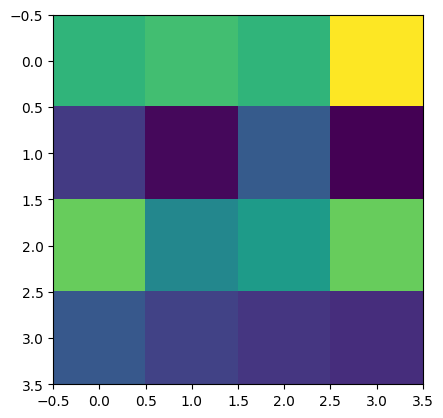

In [ ]:
import matplotlib.pyplot as plt

index = 1

plt.figure()
plt.imshow(train_data_loader.dataset.tensors[0][index])
print("Corresponding Label:", train_data_loader.dataset.tensors[1][index])

# save the image
plt.figure()
plt.imsave('BAS_Image_Example.png', train_data_loader.dataset.tensors[0][index])

We can separate each datasets in two part for the training and testing:

In [7]:
from Data_Loading.toolbox_data import create_pytorch_dataset

batch_size = 1
training_sizetrain_dataset_number = 150
test_dataset_number = 50

# Split the data into training and test sets
def BAS_Custom_MSE(data, train_dataset_number, test_dataset_number, batch_size):
    """ Load the BAS dataset from Pennylane. The dataset is composed only composed of 2 classes.
    Args:
        - data: the dataset to be used
        - train_dataset_number: number of training samples to keep (int, less than 1000)
        - test_dataset_number: number of testing samples to keep (int, less than 200)
        - batch_size: size of the batch (int)
    Output:
        - train_dataloader: training dataloader
        - test_dataloader: testing dataloader
    """
    x_train = np.array([data[i][1] for i in range(train_dataset_number)]) # vector representations images
    y_train = np.array([data[i][0] for i in range(train_dataset_number)]) # labels for the above images  
    x_test = np.array([data[i][1] for i in range(train_dataset_number, train_dataset_number+test_dataset_number)]) # vector representations of images
    y_test = np.array([data[i][0] for i in range(train_dataset_number, train_dataset_number+test_dataset_number)]) # labels for the above images
    y_train_vector, y_test_vector = np.zeros((train_dataset_number,2)), np.zeros((test_dataset_number,2)) # labels for the above images
    # Reshape the data:
    x_train, x_test = x_train[:train_dataset_number].reshape(train_dataset_number, 4,4), x_test[:test_dataset_number].reshape(test_dataset_number, 4,4)
    y_train, y_test = y_train[:train_dataset_number], y_test[:test_dataset_number]
    # Vectorize labels:
    for index, value in enumerate(y_train):
        if value == 1: # Transform label 1 to label torch.tensor([0,1])
            y_train_vector[index][1] = 1
        elif value == 0: # Transform label 0 to label torch.tensor([1,0])
            y_train_vector[index][0] = 1
        else:
            print("Errors with labels")
    for index, value in enumerate(y_test):
        if value == 1: # Transform label 1 to label torch.tensor([0,1])
            y_test_vector[index][1] = 1
        elif value == 0: # Transform label 0 to label torch.tensor([1,0])
            y_test_vector[index][0] = 1
        else:
            print("Errors with labels")
    print("Train data and label tensors of size:{} and {}".format(np.shape(x_train), np.shape(y_train)))
    print("Test data and label tensors of size:{} and {}".format(np.shape(x_test), np.shape(y_test)))
    # Convert numpy arrays to PyTorch tensors and form dataloaders
    return create_pytorch_dataset(x_train, y_train_vector, x_test, y_test_vector, batch_size)

# Load the data
train_dataloader_02, test_dataloader_02 = BAS_Custom_MSE(data_02, training_sizetrain_dataset_number, test_dataset_number, batch_size)


Train data and label tensors of size:(150, 4, 4) and (150,)
Test data and label tensors of size:(50, 4, 4) and (50,)


We can try our Photonic QCNN:

In [8]:
from qoptcraft.basis import get_photon_basis, hilbert_dim
from Layers.Linear_Optics import *
from Layers.measurement import *
from Layers.toolbox_basis_change import Basis_Change_Image_to_Fock_density, Basis_Change_Image_to_larger_Fock_density
from Layers.HW_preserving_QCNN.Conv import Conv_RBS_density_I2
from Layers.HW_preserving_QCNN.Pooling import Pooling_2D_density_HW
from Layers.toolbox import PQNN



class_set = [0, 1]
nbr_rows, nbr_cols = 4, 4 

### Hyperparameters:
m = nbr_rows + nbr_cols #number of modes in total
add1, add2 = 1, 1
nbr_class = 2
list_gates = [(2,3),(1,2),(3,4),(0,1),(2,3),(4,5),(1,2),(3,4),(0,1),(2,3),(4,5),(1,2),(3,4)]
modes_detected = [2,3]

photon_basis = get_photon_basis(m, 2)
dimension = hilbert_dim(m, 2)
print("Hilbert space dimension: ", dimension)

# Define the network:
#criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.MSELoss()
device = torch.device("cpu")


class Photonic_QCNN(nn.Module):
    """ A class defining the fully connected neural network """
    def __init__(self, m, list_gates, modes_detected, device):
        super(Photonic_QCNN, self).__init__()
        self.device = device
        self.Conv = Conv_RBS_density_I2(m//2, 2, device)
        self.Pool = Pooling_2D_density_HW(m//2, m//4, device)
        self.toFock = Basis_Change_Image_to_larger_Fock_density(m//4, m//4, add1, add2, device)
        self.dense = VQC_Fock_BS_density(2, m//2 + add1 + add2, list_gates,device)
        self.measure = Measure_Photon_detection(2, m//2 + add1 + add2, modes_detected, device)
        #self.toFock =  Basis_Change_Image_to_Fock_density(m//4,m//4,device)
        #self.dense = VQC_Fock_BS_density(2, m//2, list_gates,device)
        #self.measure = Measure_Photon_detection(2, m//2, 0, device)
    def forward(self, x):
        x = self.Conv(x)
        x = self.Pool(x)
        return self.measure(self.dense(self.toFock(x)))
       

network_dense = Photonic_QCNN(m,  list_gates, modes_detected, device)

Hilbert space dimension:  36


In [9]:
import torch.nn.functional as F
from torch.optim.lr_scheduler import ExponentialLR
from Training.training import train_globally_MSE

#optimizer = torch.optim.SGD(network_dense.parameters())
optimizer = torch.optim.Adam(network_dense.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = ExponentialLR(optimizer, gamma=0.9)
output_scale, train_epochs, test_interval = 1, 30, 1

network_state, training_loss_list, training_accuracy_list, testing_loss_list, testing_accuracy_list = train_globally_MSE(batch_size, 4, network_dense, train_dataloader_02, test_dataloader_02, optimizer, scheduler,
                                  criterion, output_scale, train_epochs, test_interval, device)

Start training! Number of network total parameters: 15


/opt/anaconda3/envs/photonic_env/lib/python3.11/site-packages/torch/_tensor.py:889: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Evaluation on test set: Loss = 0.232456, accuracy = 56.0000 %
Epoch 0: Loss = 0.232336, accuracy = 58.6667 %, time=1.2513s
Epoch 1: Loss = 0.205300, accuracy = 73.3333 %, time=1.2704s
Evaluation on test set: Loss = 0.195108, accuracy = 78.0000 %
Epoch 2: Loss = 0.183017, accuracy = 81.3333 %, time=1.3071s
Evaluation on test set: Loss = 0.179397, accuracy = 88.0000 %
Epoch 3: Loss = 0.166446, accuracy = 89.3333 %, time=1.2639s
Evaluation on test set: Loss = 0.167903, accuracy = 88.0000 %
Epoch 4: Loss = 0.154885, accuracy = 89.3333 %, time=1.3095s
Evaluation on test set: Loss = 0.159793, accuracy = 88.0000 %
Epoch 5: Loss = 0.146887, accuracy = 90.0000 %, time=1.3114s
Evaluation on test set: Loss = 0.154004, accuracy = 88.0000 %
Epoch 6: Loss = 0.141235, accuracy = 92.0000 %, time=1.2482s
Evaluation on test set: Loss = 0.149758, accuracy = 90.0000 %
Epoch 7: Loss = 0.137117, accuracy = 92.0000 %, time=1.2451s
Evaluation on test set: Loss = 0.146561, accuracy = 92.0000 %
Epoch 8: Loss = 

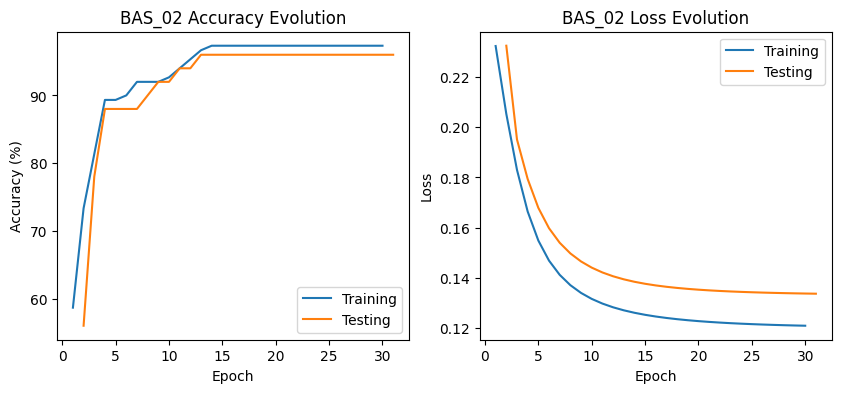

In [10]:
import matplotlib.pyplot as plt

figure, axis = plt.subplots(1, 2, figsize=(10,4))

# Accuracy
axis[0].plot([i+1 for i in range(len(training_accuracy_list))], training_accuracy_list, label='Training')
axis[0].plot([i+2 for i in range(len(testing_accuracy_list))], [i* 100 for i in testing_accuracy_list], label='Testing')
axis[0].set_title('BAS_02 Accuracy Evolution')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Accuracy (%)')
axis[0].legend()
# Loss
axis[1].plot([i+1 for i in range(len(training_accuracy_list))], training_loss_list, label='Training')
axis[1].plot([i+2 for i in range(len(testing_accuracy_list))], testing_loss_list, label='Testing')
axis[1].set_title('BAS_02 Loss Evolution')
axis[1].set_ylabel('Loss')
axis[1].set_xlabel('Epoch')
axis[1].legend()
plt.savefig('Custom_BAS_02_MSE.pdf', dpi=120, format='pdf', bbox_inches='tight')
# Combine all the operations and display
plt.show()

We do the same for the 0.4 dataset:

In [20]:
# Load the data
train_dataloader_04, test_dataloader_04 = BAS_Custom_MSE(data_04, training_sizetrain_dataset_number, test_dataset_number, batch_size)

Train data and label tensors of size:(150, 4, 4) and (150,)
Test data and label tensors of size:(50, 4, 4) and (50,)


In [21]:
class_set = [0, 1]
nbr_rows, nbr_cols = 4, 4 

### Hyperparameters:
m = nbr_rows + nbr_cols #number of modes in total
add1, add2 = 1, 1
nbr_class = 2
list_gates = [(2,3),(1,2),(3,4),(0,1),(2,3),(4,5),(1,2),(3,4),(0,1),(2,3),(4,5),(1,2),(3,4)]
modes_detected = [2,3]

photon_basis = get_photon_basis(m, 2)
dimension = hilbert_dim(m, 2)
print("Hilbert space dimension: ", dimension)

# Define the network:
#criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.MSELoss()
device = torch.device("cpu")

network_dense_2 = Photonic_QCNN(m,  list_gates, modes_detected, device)

Hilbert space dimension:  36


In [22]:
#optimizer = torch.optim.SGD(network_dense.parameters())
optimizer = torch.optim.Adam(network_dense_2.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = ExponentialLR(optimizer, gamma=0.9)
output_scale, train_epochs, test_interval = 1, 30, 1

network_state_2, training_loss_list_2, training_accuracy_list_2, testing_loss_list_2, testing_accuracy_list_2 = train_globally_MSE(batch_size, 4, network_dense_2, train_dataloader_04, test_dataloader_04, optimizer, scheduler,
                                  criterion, output_scale, train_epochs, test_interval, device)

Start training! Number of network total parameters: 15


/opt/anaconda3/envs/photonic_env/lib/python3.11/site-packages/torch/_tensor.py:889: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Evaluation on test set: Loss = 0.239039, accuracy = 58.0000 %
Epoch 0: Loss = 0.306103, accuracy = 40.6667 %, time=1.2563s
Epoch 1: Loss = 0.289052, accuracy = 40.0000 %, time=1.2697s
Evaluation on test set: Loss = 0.239396, accuracy = 56.0000 %
Epoch 2: Loss = 0.279516, accuracy = 40.0000 %, time=1.2250s
Evaluation on test set: Loss = 0.241730, accuracy = 56.0000 %
Epoch 3: Loss = 0.273149, accuracy = 40.0000 %, time=1.2506s
Evaluation on test set: Loss = 0.243540, accuracy = 56.0000 %
Epoch 4: Loss = 0.268298, accuracy = 39.3333 %, time=1.2357s
Evaluation on test set: Loss = 0.244805, accuracy = 56.0000 %
Epoch 5: Loss = 0.264279, accuracy = 39.3333 %, time=1.2442s
Evaluation on test set: Loss = 0.245620, accuracy = 56.0000 %
Epoch 6: Loss = 0.260788, accuracy = 38.6667 %, time=1.2214s
Evaluation on test set: Loss = 0.246083, accuracy = 56.0000 %
Epoch 7: Loss = 0.257675, accuracy = 42.0000 %, time=1.2461s
Evaluation on test set: Loss = 0.246277, accuracy = 62.0000 %
Epoch 8: Loss = 

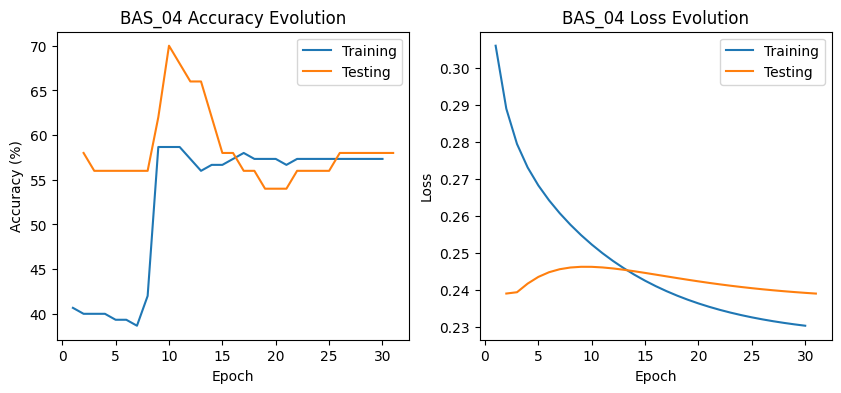

In [23]:
figure, axis = plt.subplots(1, 2, figsize=(10,4))

# Accuracy
axis[0].plot([i+1 for i in range(len(training_accuracy_list_2))], training_accuracy_list_2, label='Training')
axis[0].plot([i+2 for i in range(len(testing_accuracy_list_2))], [i* 100 for i in testing_accuracy_list_2], label='Testing')
axis[0].set_title('BAS_04 Accuracy Evolution')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Accuracy (%)')
axis[0].legend()
# Loss
axis[1].plot([i+1 for i in range(len(training_accuracy_list_2))], training_loss_list_2, label='Training')
axis[1].plot([i+2 for i in range(len(testing_accuracy_list_2))], testing_loss_list_2, label='Testing')
axis[1].set_title('BAS_04 Loss Evolution')
axis[1].set_ylabel('Loss')
axis[1].set_xlabel('Epoch')
axis[1].legend()
plt.savefig('Custom_BAS_04_MSE.pdf', dpi=120, format='pdf', bbox_inches='tight')
# Combine all the operations and display
plt.show()